# Анализ пользователей сети фитнес-центров «Культурист-датасаентист»

Задача: провести анализ пользователей сети фитнес-центров "Культурист-датасаентист" и подготовить план действий по удержанию клиентов
    - спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
    - сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
    - проанализировать основные признаки, наиболее сильно влияющие на отток;
    - сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
        1) выделить целевые группы клиентов;
        2) предложить меры по снижению оттока;
        3) определить другие особенности взаимодействия с клиентами.

## 1. Изучение и подготовка данных к анализу

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

gym_churn = pd.read_csv('/datasets/gym_churn.csv')
display(gym_churn.head())
print(gym_churn.info())
print(gym_churn.duplicated().sum())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB
None
0


В данных всего 4 000 наблюдений, 14 признаков, отсутствуют пропущенные значения, отсутствуют дубликаты. Типы данных соответсвуют.

## 2. Исследовательский анализ данных

In [2]:
#изучим средние значения и стандартные отклонения признаков
display(gym_churn.describe())

#изучим средние значения в группах тех, кто ушел и тех, кто остался
display(gym_churn.groupby('Churn').mean())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


В среднем в данных все клиенты равномерно распределены по половому признаку (50/50), примерно 84,5% клиентов живут или работают рядом с фитнес центром, около 50% клиентов являются сотрудниками компаний партнеров, 30% клиентов пришли по акции "приведи друга", средний контрактный период составляет около 5 месяцев, 41% клиентов посещают групповые занятия, средний возраст клиентов 29 лет, среднее время с момента первого обращения в фитнес центр около 4 месяцев, средняя частота посещений в неделю 1,9 раза, средний отток клиентов составяет 26,5%. 

Что касается, клиентов, которые ушли в отток и тех, кто остался. По половому признаку клиенты распределены равномерно, удаленность от фитнес центра не сильно влияет на отток (76,8% клиентов кто ушел живут или работают рядом с фитнес центром), если клиент является сотрудников компании партнера, то в среднем их отток меньше на 17,9%, также, если клиент пришел по акции "приведи друга", то отток меньше почти в 2 раза, средний контрактный период у тех, кто остался составляет около 6 месяцев, а у тех, кто ушел около 2х месяцев, стабильные клиенты почти в 2 раза чаще посещают групповые занятия, средний возраст клиентов, попадаюх в отток 26-27 лет, остаются чаще клиенты в возрасте 29-30 лет, среднее время с момета последнего обращения у тех, кто ушел в отток составляет 1 месяц, а у оставшихся 4,7 мес., средняя частота посещения фитнес-центра в неделю у тех, кто остался 2 раза, у тех, кто ушел 1,5 раза. 

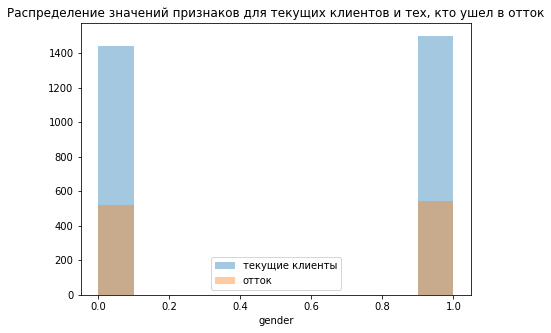

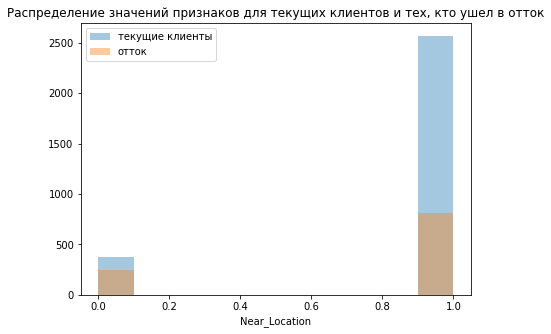

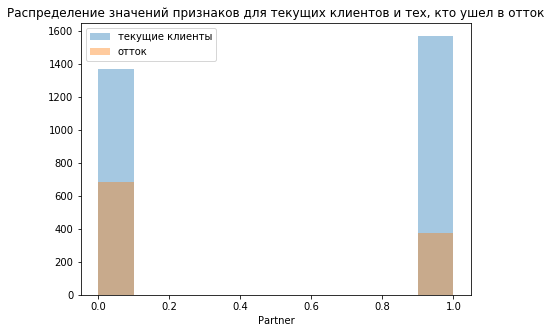

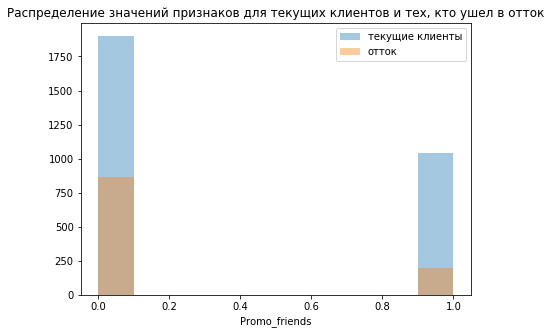

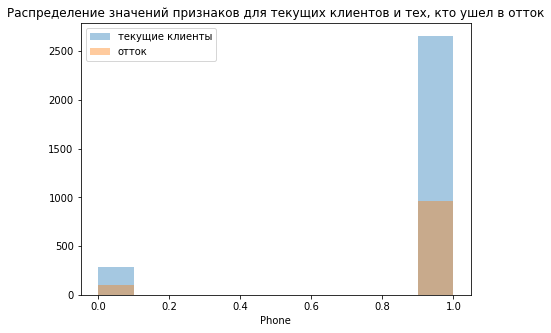

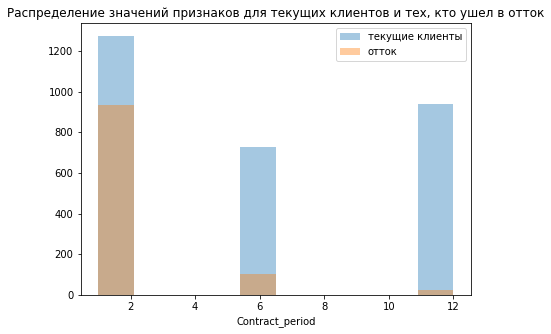

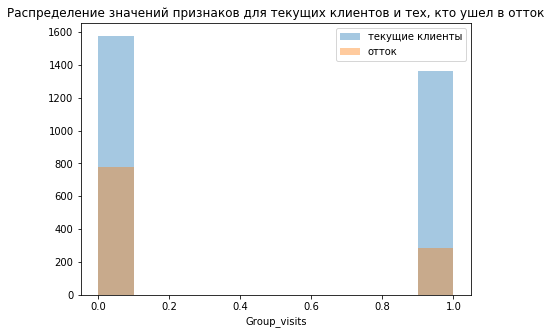

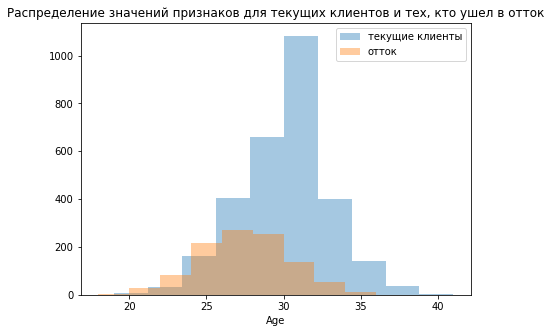

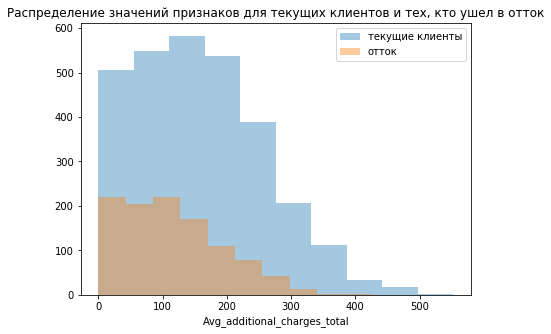

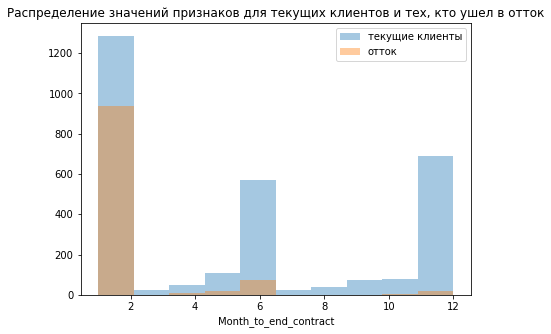

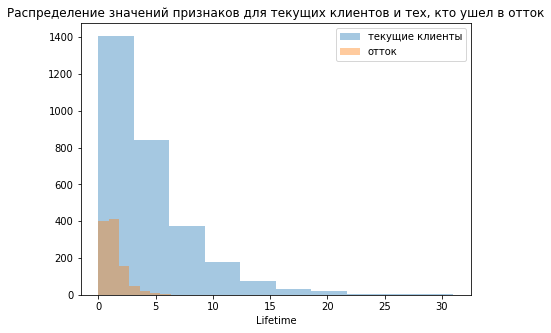

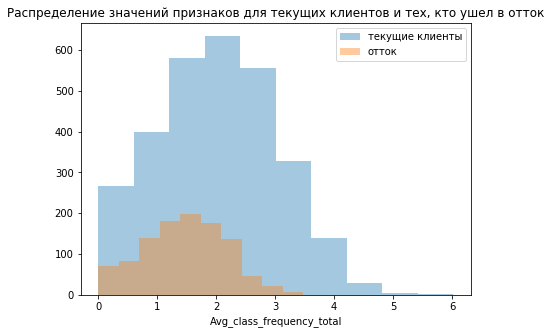

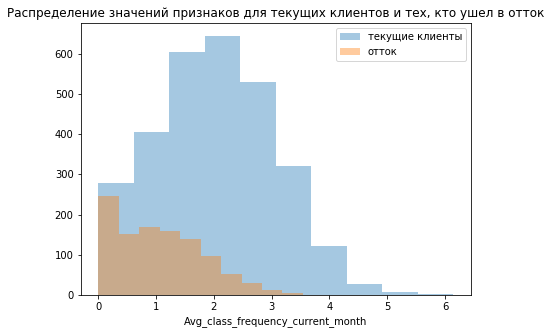

In [3]:
#постройм столбчатые гистограммы и распределения признаков для тех, кто ушёл и тех, кто остался
gym_churn_0 = gym_churn.query('Churn == "0"')
gym_churn_1 = gym_churn.query('Churn == "1"')

for feature in gym_churn.drop('Churn',axis=1).columns:
    fig = plt.gcf()
    fig.set_size_inches(7, 5)
    sns.distplot(gym_churn_0[feature], bins = 10, label='текущие клиенты', kde=False)
    sns.distplot(gym_churn_1[feature], bins = 10, label='отток', kde=False)
    plt.legend()
    plt.title('Распределение значений признаков для текущих клиентов и тех, кто ушел в отток')
    plt.show()
    

Больше всего в "отток" уходят следующие клиенты:
- проживающие или работающие в дали от фитнес-центра,
- которые НЕ являеются сотрудниками компаний-партнеров,
- которые НЕ пользовались акцией "приведи друга",
- которые взяли абонемент на месяц (меньше всего отток у клиентов, которые взяли абонемент на год),
- которые НЕ посещают групповые занятия,
- в возрасте от 20 до 30 (наиболее постоянные клиенты в возрасте от 30 до 35 лет),
- у которых, срок окончания абонемента составляет 1 месяц и меньше,
- у которых средняя частота посещений фитнеса в неделю составляет 0-2 раза (чем больше количество посещений в неделю, тем меньше отток клиентов),
- больше всего клиентов теряется в первые 2 месяца с момета обращения в фитнес-центр
- наибольший отток происходит если клиент в прошлом месяце не посещял фитнес центр 

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
Near_Location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
Partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
Promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
Phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
Contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
Group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
Age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
Avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
Month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


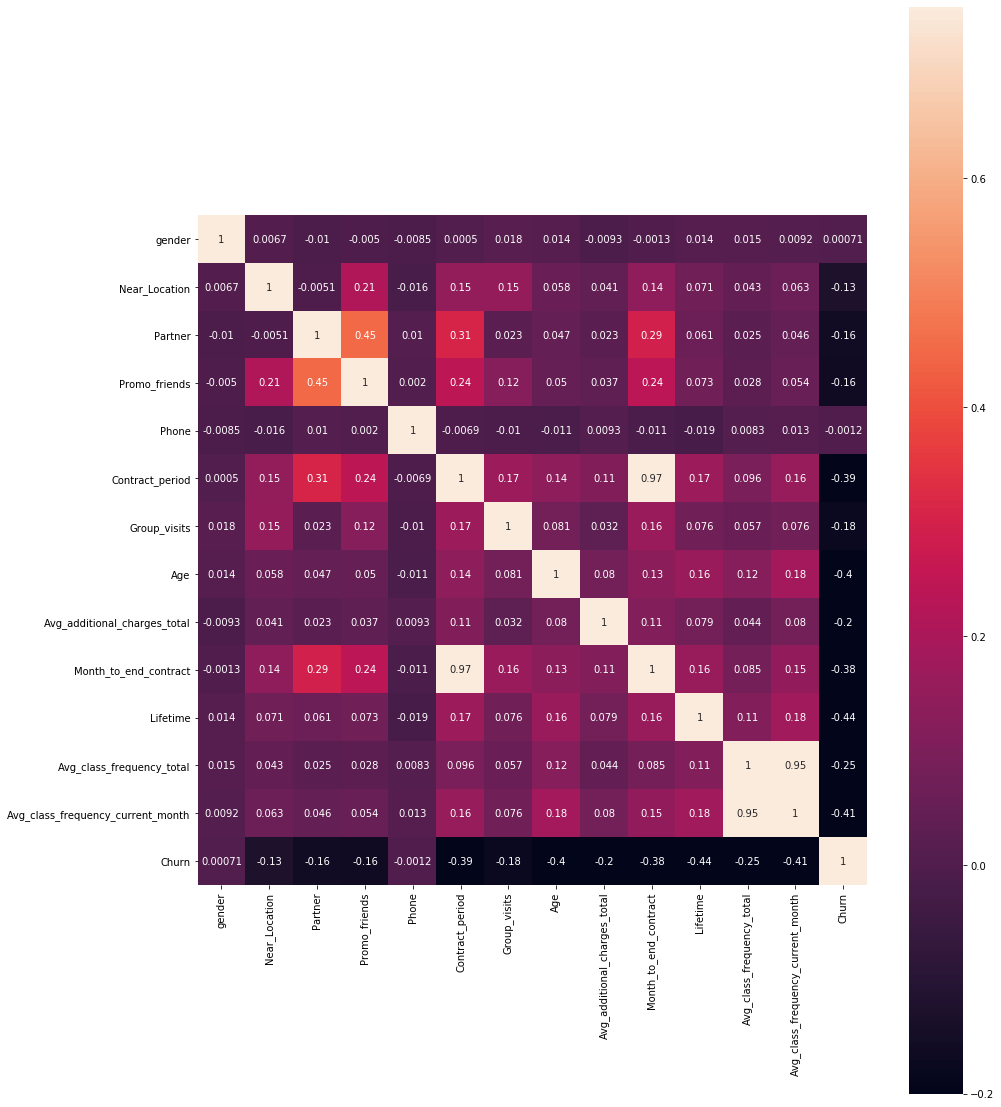

In [4]:
#построим матрицу корреляций 
cm = gym_churn.corr()
display(cm)

fig, ax = plt.subplots()
fig.set_size_inches(15, 20)
sns.heatmap(cm, annot = True, square=True, vmax = 0.75, vmin = -0.2)
plt.show()

Среднюю прямую зависимость имеют такие параметры, как: сотрудник компании-партнёра клуба, факт первоначальной записи в рамках акции «приведи друга» и длительность текущего действующего абонемента. Наиболее высокая обратная зависимость у следующих параметров: оттока клиентов и времени с первого обращения в фитнес-центр, а также длительности текущего абонемента.   

## 3. Прогнозирование оттока пользователей

In [5]:
#разделим данные на признаки (матрица X) и целевую переменную (y)
X = gym_churn.drop('Churn', axis=1)
y = gym_churn['Churn']

#разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)

# обучаем StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(solver = 'lbfgs')

# обучим модель
lr_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

# выведим метрики для полученного прогноза
print('Метрики для модели логистической регрессии:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, lr_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, lr_predictions)))
print('Recall: {:.2f}'.format((recall_score(y_test, lr_predictions))))
print('F1: {:.2f}'.format(f1_score(y_test, lr_predictions)))
print()

# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

rf_model.fit(X_train_st, y_train)

rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

print('Метрики для модели случайного леса:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format((recall_score(y_test, rf_predictions))))
print('F1: {:.2f}'.format(f1_score(y_test, rf_predictions)))

Метрики для модели логистической регрессии:
Accuracy: 0.94
Precision: 0.90
Recall: 0.85
F1: 0.87

Метрики для модели случайного леса:
Accuracy: 0.92
Precision: 0.88
Recall: 0.83
F1: 0.85


При использовании модели логистической регрессии доля верно угаданных ответов из всех прогнозов составляет 95%, эта же метрика при использовании модели случайного леса составляет 97%. Аналогично метрики точности (Precision) и полноты (recall) при использовании модели случайного леса выше на 2%. Следовательно модель случайного леса в данном случае показала себя лучше. 

## 4. Кластеризация пользователей

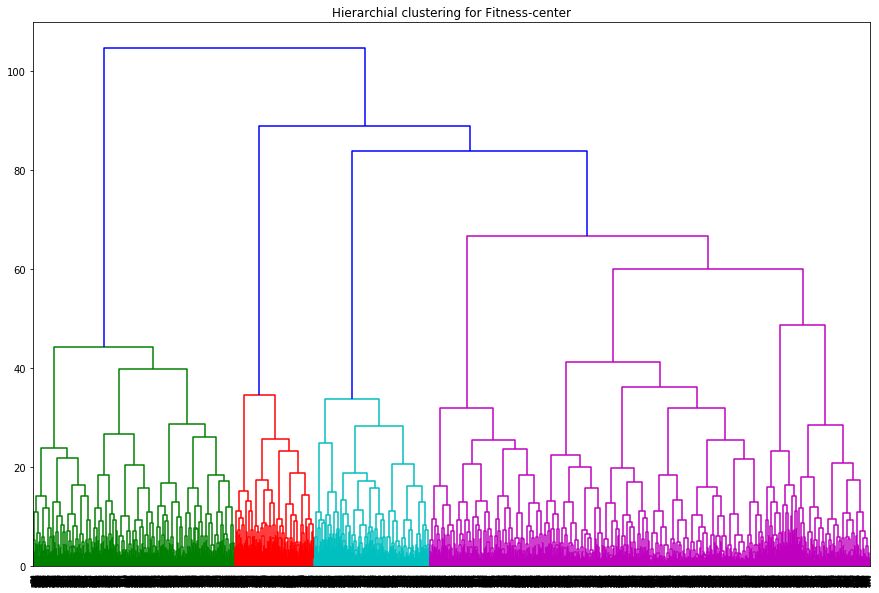

In [6]:
#убираем переменную churn из данных
gym = gym_churn.drop('Churn', axis=1)

#стандартизируем данные перед работой с алгоритмами
sc = StandardScaler()
gym_sc = sc.fit_transform(gym)

linked = linkage(gym_sc, method = 'ward')

#рисуем дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for Fitness-center')
plt.show()


Исходя из дендрограммы можно выделить 4 различных сегмента (кластера), на графике они указаны разными цветами.

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster_km,,,,,,,,,,,,,,
0,0.502473,0.959446,0.783383,0.574679,1.000000,10.884273,0.543027,29.980218,160.706969,9.950544,4.738872,1.983305,1.976225,0.027695
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.560335,0.976105,0.356033,0.229391,0.998805,2.665472,0.473118,30.127838,161.724258,2.455197,4.896057,2.851531,2.849473,0.068100


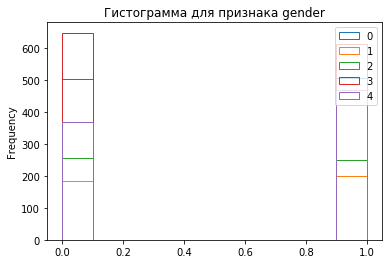

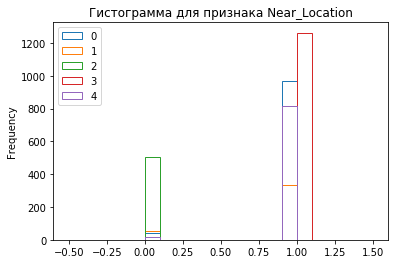

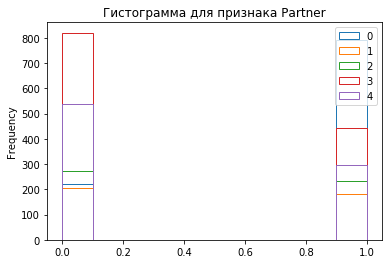

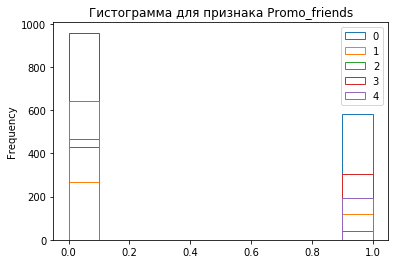

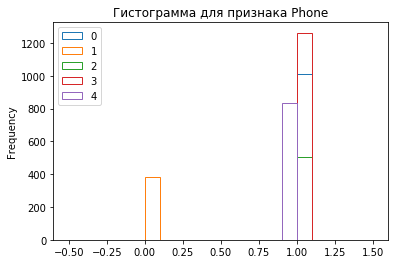

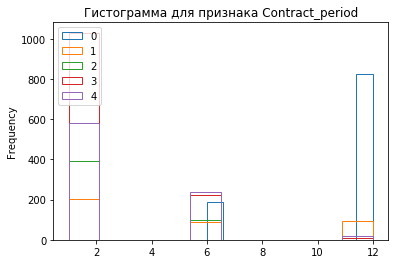

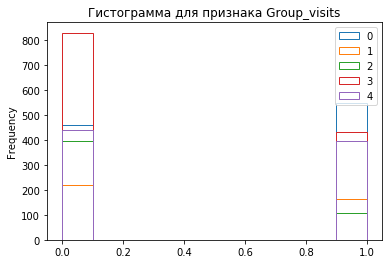

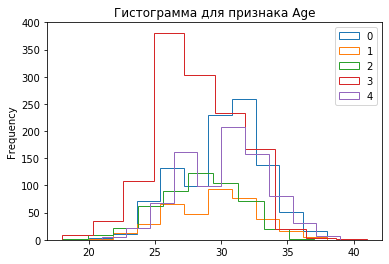

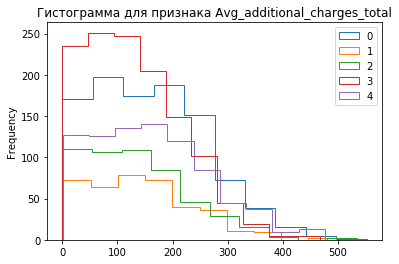

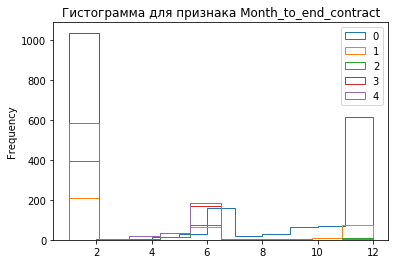

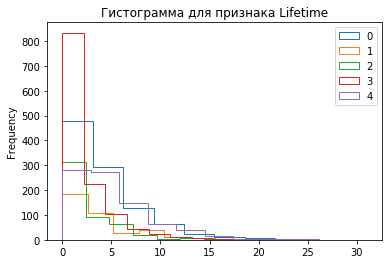

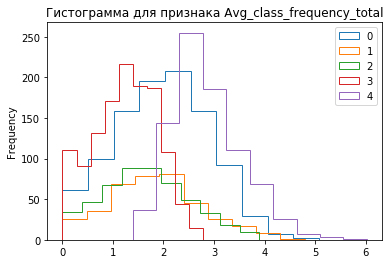

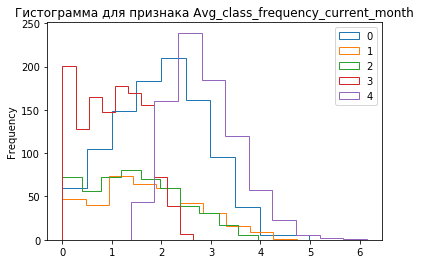

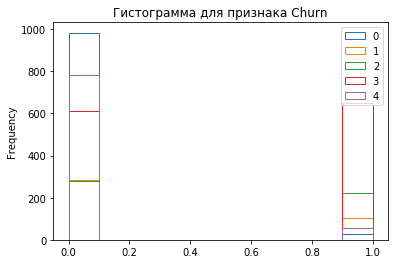

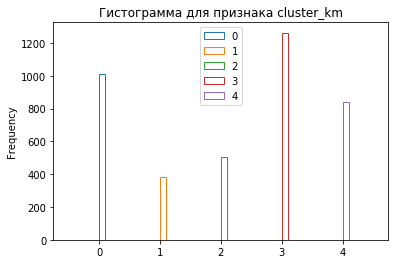

In [7]:
#обучим модель кластеризации на основании алгоритма K-Means 
km = KMeans(n_clusters = 5, random_state = 0) 
labels = km.fit_predict(gym_sc) 

gym_churn['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
display(gym_churn.groupby('cluster_km').mean())

#постройм столбчатые гистограммы и распределения признаков для кластеров
for column in gym_churn:
    gym_churn.groupby('cluster_km')[column].plot(kind='hist', 
                                                 alpha=1, 
                                                 histtype = 'step', 
                                                 title='Гистограмма для признака '+ str(column), 
                                                 legend = True)
    plt.show()
    
  

Всего 5 сегментов:

Сегмент 0 - клиенты, проживающие или работающие рядом с фитнес-ценром, большая часть клиентов являются клиентам компаний-партнеров, 57% пришли по акции "приведи друга", средний контрактный период около 11 месяцев, 50% посещают групповые занятия, средний возраст 29-30 лет, средняя частота посещеня фитнес центра 2 раза в неделю, отток 2,8%;

Сегмент 1 - проживают или работают рядом с фитнес-центром, 47% клиентов являются клиентам компаний-партнеров, 30% пришли по акции "приведи друга", контрактный период 4,9 месяцев, 43% посещают групповые занятия,средний возраст 29 лет, среднее число посещений в неделю 1,8 раза, отток 26,8%;

Сегмент 2 - клиенты, проживающие или работающие далеко от фитнес-ценра, контрактный период составляет в среднем 2,4 месяца, мало посещают групповые занятия, средний возраст 28 лет, количество посещений в неделю 1,7 раза, отток 44,4%;

Сегмент 3 - клиенты, проживающие или работающие рядом с фитнес-ценром, 24% клиентов являются клиентам компаний-партнеров, контрактный период составляет в среднем 1,9 месяцев, 30% клиентов посещают групповые занятия, средний возраст 28 лет, количество посещений в неделю 1,2 раза, отток 51,4%;

Сегмент 4 - клиенты, проживающие или работающие рядом с фитнес-ценром, 35% клиентов являются клиентам компаний-партнеров, 23% пришли по акции "приведи друга", контрактный период составляет в среднем около 2,7 месяцев, почти половина клиентов посещают групповые занятия, средний возраст 30 лет, количество посещений в неделю 2,9 раз, отток 6,8%.

In [8]:
#расчитаем долю оттока для каждого кластера 

churn_claster = gym_churn.query('Churn == "1"').groupby('cluster_km').agg({'Churn':'count'}).reset_index()

churn_claster['%_Churn'] = churn_claster['Churn'] / (churn_claster['Churn'].sum()) * 100
display(churn_claster)



,cluster_km,Churn,%_Churn
0,0,28,2.639020
1,1,103,9.707823
2,2,224,21.112158
3,3,649,61.168709
4,4,57,5.372290


Наиболее надежные сегменты 1, 3 и 4, в них доля оттока составляет меньше 2%. Наиболее склонны к оттоку сегмент 2 и сегмент 0.

## 5. Сформулируйте выводы и сделайте базовые рекомендации по работе с клиентами

Сильнее всего на отток влияют следующие признаки:
1. Длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год). Чем больше период действия абонемента, тем более стабильный клиент.
2. Срок до окончания текущего действующего абонемента (в месяцах). Чем меньше срок оконания абонемента, тем более вероятен отток клиента.
3. Средняя частота посещений в неделю за все время с начала действия абонемента. Чем больше посещений клиентом фитнес-центра в неделю, тем меньше вероятность его оттока.
4. Сотрудник компании-партнёра клуба. Если, клиент явяется сотрудником компании партнера клуба, то вероятность его оттока уменьшается.
5. Чем младше клиент, тем больше вероятность его оттока.
6. Использование акции "приведи друга". Данная акция приводит постоянных клиентов.
7. Посещение групповых занятий положительно влияет на стабильность посещения фитнес - центра клиентом.

Для удержания клиентов считаю необходимым:
- продолжать акцию "приведи друга", 
- расширять клиентскую базу через компаний-партнеров, 
- сделать более выгодное предложение на долгий срок абонемента,
- предлагать купить абонемент со скидкой (специальным предложением) для текущих клиентов, у которых срок окнчания подходит к концу (за месяц).
